# Log File einlesen

In [1]:
import re
import pandas as pd
import numpy as np

with open("../berechnung.log", "r") as f:
    lines = f.readlines()
    
records_player = []
records_game = []

for line in lines:
    line = line.strip()
    
    m = re.search(
        r"Pitch Result: step size: (?P<step>\d+) \| game: (?P<game_id>\w+) \| zeit: (?P<time>[\d.]+) \| anzahl frame: (?P<n_frames>\d+)",
        line
    )
    if m:
        records_game.append({
            "step": int(m["step"]),
            "game_id": m["game_id"],
            "n_frames": int(m["n_frames"]),
            "time_sec": float(m["time"]),
        })
        continue
    
    m = re.search(
        r"Result Spieler (?P<player>\w+): frame step: (?P<step>\d+) \| game: (?P<game_id>\w+) \| zeit: (?P<time>[\d.]+) \| anzahl frame: (?P<n_frames>\d+) \| params: (?P<params>{.*?}) \| method: (?P<method>[\w.]+) \| sample: (?P<samplesize>[\d(), ]+)",
        line
    )
    if m:
        params = eval(m["params"])
        records_player.append({
            "player": m["player"],
            "frames": int(m["n_frames"]),
            "step": int(m["step"]),
            "game_id": m["game_id"],
            "method": m["method"],
            "time_sec": float(m["time"]),
            "param_max_radius": params["max_radius"],
            "param_opt_step_size": params["opt_step_size"],
            "param_min_dist": params["min_dist"],
            "param_n": params["n"],
            "sample": m["samplesize"],
            "params": params
        })
        continue
    
    else:
        print(line)
    
df_games = pd.DataFrame(records_game)
df_player = pd.DataFrame(records_player)
df_player


,player,frames,step,game_id,method,time_sec,param_max_radius,param_opt_step_size,param_min_dist,param_n,sample,params
0,home_25,201,125,J03WQQ,random,391.1710,5,1.0,2,20,20,"{'max_radius': 5, 'opt_step_size': 1, 'min_dis..."
1,home_13,31,125,J03WQQ,random,41.9171,5,1.0,2,20,20,"{'max_radius': 5, 'opt_step_size': 1, 'min_dis..."
2,home_28,201,125,J03WQQ,random,304.8802,5,1.0,2,20,20,"{'max_radius': 5, 'opt_step_size': 1, 'min_dis..."
3,home_3,2,125,J03WQQ,random,2.1916,5,1.0,2,20,20,"{'max_radius': 5, 'opt_step_size': 1, 'min_dis..."
4,home_11,52,125,J03WQQ,random,68.6505,5,1.0,2,20,20,"{'max_radius': 5, 'opt_step_size': 1, 'min_dis..."
...,...,...,...,...,...,...,...,...,...,...,...,...
1489,away_30,97,125,J03WN1,all_positions_cut_0.1,567.8546,5,1.0,2,20,78,"{'max_radius': 5, 'opt_step_size': 1, 'min_dis..."
1490,away_27,97,125,J03WN1,all_positions_cut_0.1,573.3174,5,1.0,2,20,55,"{'max_radius': 5, 'opt_step_size': 1, 'min_dis..."
1491,away_23,13,125,J03WN1,all_positions_cut_0.1,54.6031,5,1.0,2,20,72,"{'max_radius': 5, 'opt_step_size': 1, 'min_dis..."
1492,away_18,1,125,J03WN1,all_positions_cut_0.1,3.2954,5,1.0,2,20,69,"{'max_radius': 5, 'opt_step_size': 1, 'min_dis..."


In [2]:
# Game DF auswerten
df_games_grouped = (df_games.groupby("step").agg(
    runs=("time_sec", "count"),
    time_sec=("time_sec", "mean"),
))
df_games_grouped["time_min"] = round(df_games_grouped["time_sec"] / 60, 2)
df_games_grouped

,runs,time_sec,time_min
step,,,
1,1,3963.246300,66.05
25,1,107.934300,1.80
125,8,26.335887,0.44
500,1,7.923100,0.13
1000,1,3.088500,0.05
10000,1,0.655700,0.01


In [3]:
# Player DF mit 125 Step auswerten
df = df_player.copy()
df["sample"] = df["sample"].apply(lambda x: int(eval(x)[0]+(eval(x)[1]*eval(x)[2])) if isinstance(eval(x), tuple) else eval(x))
df["method"] = df.apply(
    lambda row: f"{row['method']}_n{int(row['param_n'])}" if "random" in row["method"] else row["method"],
    axis=1
)
df["time_per_frame"] = df["time_sec"] / df["frames"]

by_step = (df.groupby(["step", "method"])
           .agg(runs=("time_sec", "count"),
                median_tpf=("time_per_frame", "median"))
           .reset_index()
           .sort_values(["step", "median_tpf"]))
# display(by_step)

# df = df[df["step"] == 125]

summary = (df.groupby(["method", "step"])
        .agg(runs=("time_sec", "count"),
             mean_total=("time_sec", "mean"),
             median_total=("time_sec", "median"),
             mean_tpf=("time_per_frame", "mean"),
             median_tpf=("time_per_frame", "median"),
             mean_sample=("sample", "mean"),
             median_sample=("sample", "median"),
             max_sample=("sample", "max")
        )
)
summary = summary.sort_values("median_tpf")
# display(summary)

per_player = (df.groupby(["player", "method"])
              .agg(median_tpf=("time_per_frame", "median"),
                   mean_tpf=("time_per_frame", "mean"))
              .reset_index()
            )
# display(per_player)

player_fair = (per_player.groupby("method")[["median_tpf", "mean_tpf"]]
               .median()
               .sort_values(by="median_tpf"))
# display(player_fair)

low_q, high_q = 0.05, 0.95
q_low = df.groupby(["method", "step"])["time_per_frame"].transform(lambda x: x.quantile(low_q))
q_high = df.groupby(["method", "step"])["time_per_frame"].transform(lambda x: x.quantile(high_q))

df_trim = df[(df["time_per_frame"].between(q_low, q_high))].copy()

pivot_total = pd.pivot_table(
    df,
    index=["step"],
    columns="method",
    values=["time_sec"],
    aggfunc="mean"
).round(3)
pivot_total_trim = pd.pivot_table(
    df_trim,
    index=["step"],
    columns="method",
    values=["time_sec"],
    aggfunc="mean"
).round(3)
pivot_mean = pd.pivot_table(
    df,
    index=["step"],
    columns="method",
    values=["time_per_frame"],
    aggfunc="mean"
).round(3)
pivot_mean_trim = pd.pivot_table(
    df_trim,
    index=["step"],
    columns="method",
    values=["time_per_frame"],
    aggfunc="mean"
).round(3)
pivot_max = pd.pivot_table(
    df,
    index=["step"],
    columns="method",
    values=["time_per_frame"],
    aggfunc="max"
).round(3)
pivot_max_trim = pd.pivot_table(
    df_trim,
    index=["step"],
    columns="method",
    values=["time_per_frame"],
    aggfunc="max"
).round(3)
display(pivot_total)
# display(pivot_total_trim)
display(pivot_mean)
# display(pivot_mean_trim)
display(pivot_max)
# display(pivot_max_trim)

time_sec                                               \
method all_positions all_positions_cut_0.1 all_positions_cut_0.25   
step                                                                
25               NaN                   NaN                    NaN   
125          586.746               431.322                204.297   
500              NaN                   NaN                    NaN   
1000             NaN                   NaN                    NaN   

                                                                           \
method all_positions_cut_0.5 all_positions_cut_0.75 all_positions_cut_1.0   
step                                                                        
25                       NaN                    NaN              3025.713   
125                  150.408                127.003               115.158   
500                      NaN                    NaN                   NaN   
1000                     NaN                    NaN                   NaN   

                                                             \
method grid_search grid_search_cut_0.1 grid_search_cut_0.25   
step                                                          
25             NaN                 NaN                  NaN   
125       1059.085             499.798              411.209   
500        114.599                 NaN                  NaN   
1000           NaN                 NaN                  NaN   

                            ...                                         \
method grid_search_cut_0.5  ... random_cut_0.5_n50 random_cut_0.75_n20   
step                        ...                                          
25                     NaN  ...                NaN                 NaN   
125                282.286  ...            122.513              43.169   
500                    NaN  ...                NaN                 NaN   
1000                   NaN  ...                NaN                 NaN   

                                                                   \
method random_cut_0.75_n50 random_cut_1.0_n100 random_cut_1.0_n20   
step                                                                
25                     NaN                 NaN                NaN   
125                110.168             327.152              41.58   
500                    NaN                 NaN                NaN   
1000                   NaN                 NaN                NaN   

                                                                       
method random_cut_1.0_n50 random_n100 random_n20 random_n5 random_n50  
step                                                                   
25                    NaN         NaN   2730.608       NaN        NaN  
125               101.572      970.89    179.604       NaN    539.204  
500                   NaN         NaN     27.597       NaN        NaN  
1000                  NaN         NaN     33.842    12.214        NaN  

[4 rows x 25 columns]

time_per_frame                                               \
method  all_positions all_positions_cut_0.1 all_positions_cut_0.25   
step                                                                 
25                NaN                   NaN                    NaN   
125              4.84                  5.78                  3.852   
500               NaN                   NaN                    NaN   
1000              NaN                   NaN                    NaN   

                                                                           \
method all_positions_cut_0.5 all_positions_cut_0.75 all_positions_cut_1.0   
step                                                                        
25                       NaN                    NaN                 9.888   
125                    3.883                   3.73                 3.737   
500                      NaN                    NaN                   NaN   
1000                     NaN                    NaN                   NaN   

                                                             \
method grid_search grid_search_cut_0.1 grid_search_cut_0.25   
step                                                          
25             NaN                 NaN                  NaN   
125          8.731               7.429                 8.11   
500          2.292                 NaN                  NaN   
1000           NaN                 NaN                  NaN   

                            ...                                         \
method grid_search_cut_0.5  ... random_cut_0.5_n50 random_cut_0.75_n20   
step                        ...                                          
25                     NaN  ...                NaN                 NaN   
125                   7.01  ...              3.098               1.241   
500                    NaN  ...                NaN                 NaN   
1000                   NaN  ...                NaN                 NaN   

                                                                   \
method random_cut_0.75_n50 random_cut_1.0_n100 random_cut_1.0_n20   
step                                                                
25                     NaN                 NaN                NaN   
125                  3.192               5.545              1.378   
500                    NaN                 NaN                NaN   
1000                   NaN                 NaN                NaN   

                                                                       
method random_cut_1.0_n50 random_n100 random_n20 random_n5 random_n50  
step                                                                   
25                    NaN         NaN      2.722       NaN        NaN  
125                 3.309       7.253      1.465       NaN      4.506  
500                   NaN         NaN      0.552       NaN        NaN  
1000                  NaN         NaN      1.538     0.555        NaN  

[4 rows x 25 columns]

time_per_frame                                               \
method  all_positions all_positions_cut_0.1 all_positions_cut_0.25   
step                                                                 
25                NaN                   NaN                    NaN   
125            24.376                11.725                  9.916   
500               NaN                   NaN                    NaN   
1000              NaN                   NaN                    NaN   

                                                                           \
method all_positions_cut_0.5 all_positions_cut_0.75 all_positions_cut_1.0   
step                                                                        
25                       NaN                    NaN                 9.888   
125                    8.336                  9.783                 9.497   
500                      NaN                    NaN                   NaN   
1000                     NaN                    NaN                   NaN   

                                                             \
method grid_search grid_search_cut_0.1 grid_search_cut_0.25   
step                                                          
25             NaN                 NaN                  NaN   
125         25.226               11.21               36.456   
500          2.292                 NaN                  NaN   
1000           NaN                 NaN                  NaN   

                            ...                                         \
method grid_search_cut_0.5  ... random_cut_0.5_n50 random_cut_0.75_n20   
step                        ...                                          
25                     NaN  ...                NaN                 NaN   
125                 10.529  ...              3.917               1.574   
500                    NaN  ...                NaN                 NaN   
1000                   NaN  ...                NaN                 NaN   

                                                                   \
method random_cut_0.75_n50 random_cut_1.0_n100 random_cut_1.0_n20   
step                                                                
25                     NaN                 NaN                NaN   
125                  4.579               5.545              2.144   
500                    NaN                 NaN                NaN   
1000                   NaN                 NaN                NaN   

                                                                       
method random_cut_1.0_n50 random_n100 random_n20 random_n5 random_n50  
step                                                                   
25                    NaN         NaN      2.722       NaN        NaN  
125                 4.487       8.621     23.574       NaN     30.326  
500                   NaN         NaN      1.919       NaN        NaN  
1000                  NaN         NaN      1.538     0.555        NaN  

[4 rows x 25 columns]

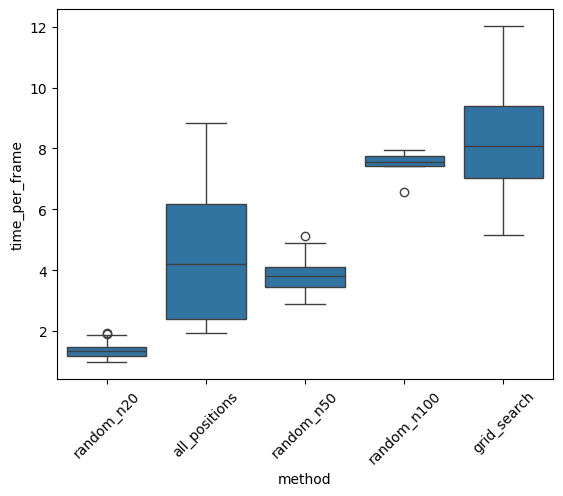

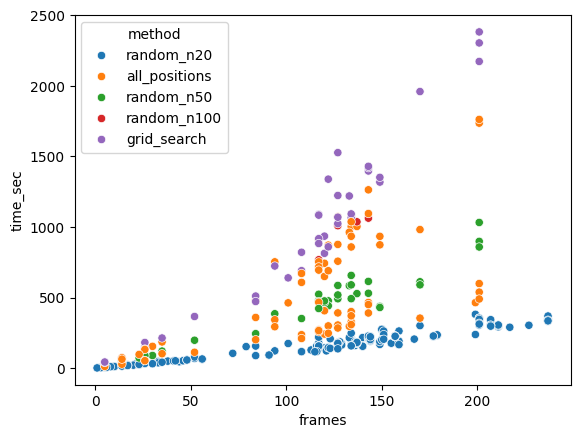

In [4]:
import seaborn as sns, matplotlib.pyplot as plt
df_125 = df_trim[df_trim["step"] == 125]
no_cut_mask = ~df_125["method"].str.contains("cut", case=False, na=False)
df_125 = df_125[no_cut_mask]
sns.boxplot(data=df_125, x="method", y="time_per_frame"); plt.xticks(rotation=45); plt.show()
sns.scatterplot(data=df_125, x="frames", y="time_sec", hue="method"); plt.show()


In [5]:
# Comp Zeiten aufbereiten für Merger mit Ergebnissen
df_merger = pd.DataFrame()
df_merger[["step", "game_id", "player_id", "method"]] = df_player[["step", "game_id", "player", "method"]]
df_merger["step"] = "step" + df_merger["step"].astype(str)
method = df_player["method"].astype(str)
tail = method.str.split("cut_").str[-1]
base = (
    "R_" + df_player["param_max_radius"].astype(str)
    + "-S_" + df_player["param_opt_step_size"].map(lambda v: f"{v:.15g}")
    + "-D_" + df_player["param_min_dist"].astype(str)
    + "-N_" + df_player["param_n"].astype(str)
)
mask = method.str.contains("cut_", na=False)
df_merger["parameters"] = np.where(mask, base + "-C_" + tail, base)

df_merger["time_sec"] = df_player["time_sec"]

df_merger = df_merger.drop_duplicates(
    subset=["step", "game_id", "player_id", "method", "parameters"],
    keep="last"
).reset_index(drop=True)
df_merger.to_csv("output/df_log_merger.csv", index=False)